## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [2]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [5]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'./{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [8]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [9]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [10]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [11]:
def read_image_mask(fragment_id):
    
    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [12]:
# def read_image_mask(fragment_id):
    
#     images = []
    
    
#     # take CFG.in_chans random idxs
#     idxs = np.random.choice(range(65), CFG.in_chans, replace=False)

#     for i in tqdm(idxs):
        
#         img_path = CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif"
#         print(img_path)
        
#         image = cv2.imread(img_path, 0)

#         pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
#         pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

#         image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

#         images.append(image)
#     images = np.stack(images, axis=2)

#     mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
#     mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

#     mask = mask.astype('float32')
#     mask /= 255.0
    
#     return images, mask

In [13]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [14]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
valid_xyxys = np.stack(valid_xyxys)

## dataset

In [16]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [17]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [18]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [19]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

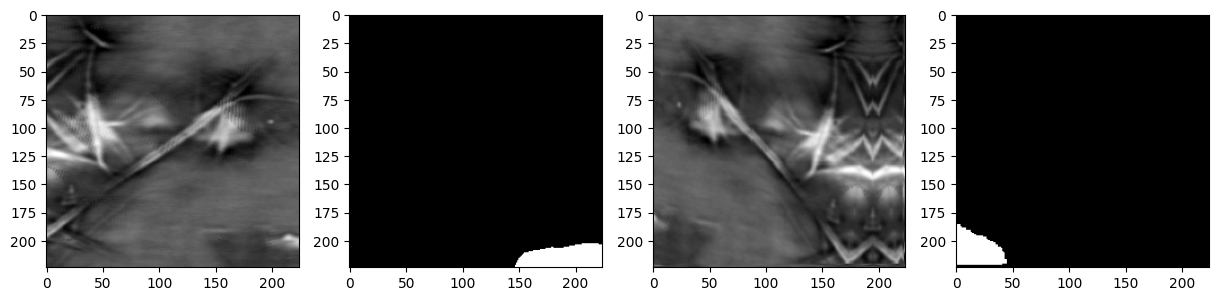

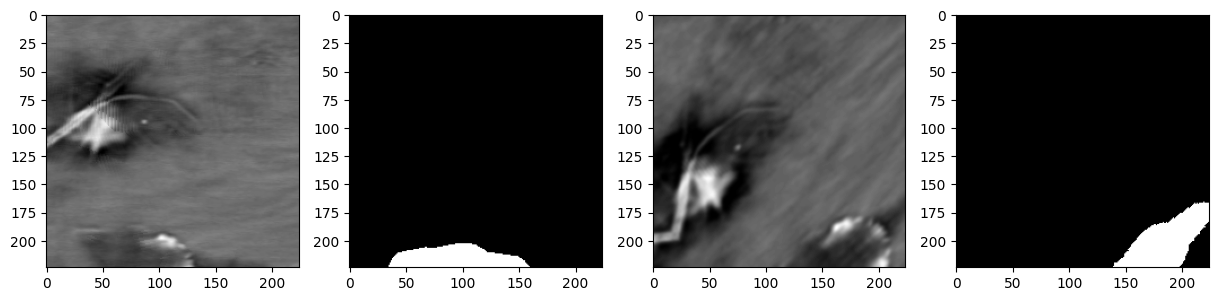

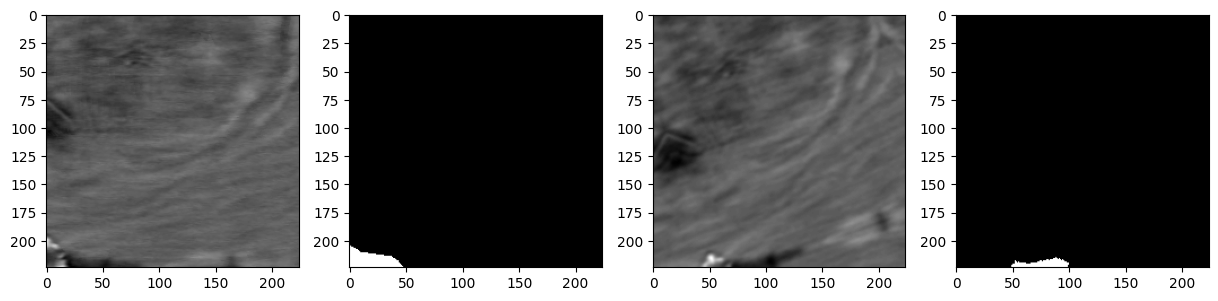

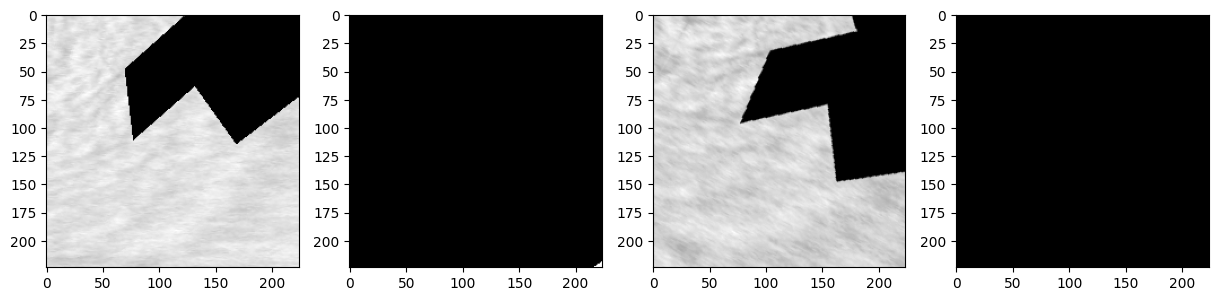

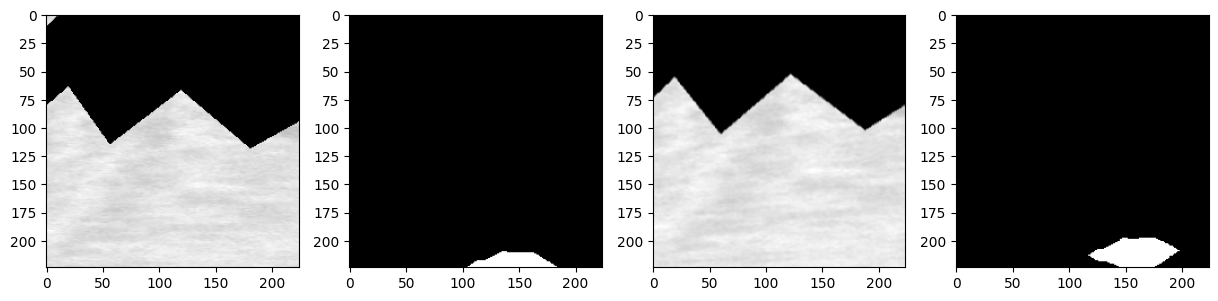

In [20]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [21]:
del plot_dataset
gc.collect()

53836

## model

In [22]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

## scheduler

In [23]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [24]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone efficientnet-b0


## loss

In [25]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    bce_loss =  BCELoss(y_pred, y_true)
    return bce_loss
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [26]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [27]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [28]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [29]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.12096148744953923
th: 0.15, fbeta: 0.12092508693473114
th: 0.2, fbeta: 0.12227844446935031
th: 0.25, fbeta: 0.20878007821830602
th: 0.3, fbeta: 0.22672197950470163
th: 0.35, fbeta: 0.23600805897180335
th: 0.4, fbeta: 0.23073366608466053
th: 0.45, fbeta: 0.20379351400199364


best_th: 0.35, fbeta: 0.23600805897180335
Epoch 1 - avg_train_loss: 0.6188  avg_val_loss: 0.4179  time: 28s
Epoch 1 - avgScore: 0.2360
Epoch 1 - Save Best Score: 0.2360 Model
Epoch 1 - Save Best Loss: 0.4179 Model


th: 0.5, fbeta: 0.13935144193113447


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.12171344296855391
th: 0.15, fbeta: 0.21617580407772788
th: 0.2, fbeta: 0.2516987184354925
th: 0.25, fbeta: 0.3010240395524247
th: 0.3, fbeta: 0.3487805670138951
th: 0.35, fbeta: 0.3784519587534365
th: 0.4, fbeta: 0.3756032776253869
th: 0.45, fbeta: 0.30754154491090524


best_th: 0.35, fbeta: 0.3784519587534365
Epoch 2 - avg_train_loss: 0.3911  avg_val_loss: 0.3224  time: 26s
Epoch 2 - avgScore: 0.3785
Epoch 2 - Save Best Score: 0.3785 Model
Epoch 2 - Save Best Loss: 0.3224 Model


th: 0.5, fbeta: 0.17334195244904255


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.3085529741478197
th: 0.15, fbeta: 0.34931321888895583
th: 0.2, fbeta: 0.38448015863088936
th: 0.25, fbeta: 0.41215898703734843
th: 0.3, fbeta: 0.433556626027673
th: 0.35, fbeta: 0.4357901974013549
th: 0.4, fbeta: 0.38011978554526954
th: 0.45, fbeta: 0.23800883053644015


best_th: 0.35, fbeta: 0.4357901974013549
Epoch 3 - avg_train_loss: 0.2841  avg_val_loss: 0.2450  time: 26s
Epoch 3 - avgScore: 0.4358
Epoch 3 - Save Best Score: 0.4358 Model
Epoch 3 - Save Best Loss: 0.2450 Model


th: 0.5, fbeta: 0.07178618796491441


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3309865152349997
th: 0.15, fbeta: 0.36343643788410224
th: 0.2, fbeta: 0.38737594280126036
th: 0.25, fbeta: 0.40246666559915256
th: 0.3, fbeta: 0.41134114278901607
th: 0.35, fbeta: 0.41348736873283287
th: 0.4, fbeta: 0.40874056108238016
th: 0.45, fbeta: 0.3923445062074321


best_th: 0.35, fbeta: 0.41348736873283287
Epoch 4 - avg_train_loss: 0.2527  avg_val_loss: 0.2413  time: 26s
Epoch 4 - avgScore: 0.4135


th: 0.5, fbeta: 0.3610335276932885


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3733490839989278
th: 0.15, fbeta: 0.4212181305289416
th: 0.2, fbeta: 0.4464177269088739
th: 0.25, fbeta: 0.46351126360598127
th: 0.3, fbeta: 0.4729427509894014
th: 0.35, fbeta: 0.4773932570748313
th: 0.4, fbeta: 0.47353022784273774
th: 0.45, fbeta: 0.4652049688193149


best_th: 0.35, fbeta: 0.4773932570748313
Epoch 5 - avg_train_loss: 0.2450  avg_val_loss: 0.2340  time: 26s
Epoch 5 - avgScore: 0.4774
Epoch 5 - Save Best Score: 0.4774 Model
Epoch 5 - Save Best Loss: 0.2340 Model


th: 0.5, fbeta: 0.4482276857777371


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.374718664364008
th: 0.15, fbeta: 0.43824599981692575
th: 0.2, fbeta: 0.47377296368996163
th: 0.25, fbeta: 0.49330304810005227
th: 0.3, fbeta: 0.5030010603708365
th: 0.35, fbeta: 0.5067522542074067
th: 0.4, fbeta: 0.5000559380319087
th: 0.45, fbeta: 0.48203489134426886


best_th: 0.35, fbeta: 0.5067522542074067
Epoch 6 - avg_train_loss: 0.2383  avg_val_loss: 0.2371  time: 26s
Epoch 6 - avgScore: 0.5068
Epoch 6 - Save Best Score: 0.5068 Model
Epoch 6 - Save Best Loss: 0.2371 Model


th: 0.5, fbeta: 0.4580429625871615


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4033987458275771
th: 0.15, fbeta: 0.45527962825475665
th: 0.2, fbeta: 0.489537602635428
th: 0.25, fbeta: 0.5131978334668679
th: 0.3, fbeta: 0.5241388363056152
th: 0.35, fbeta: 0.527756248747516
th: 0.4, fbeta: 0.5276330208004301
th: 0.45, fbeta: 0.5235308385150366


best_th: 0.35, fbeta: 0.527756248747516
Epoch 7 - avg_train_loss: 0.2272  avg_val_loss: 0.2446  time: 26s
Epoch 7 - avgScore: 0.5278
Epoch 7 - Save Best Score: 0.5278 Model
Epoch 7 - Save Best Loss: 0.2446 Model


th: 0.5, fbeta: 0.5132293452981241


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38470962795281766
th: 0.15, fbeta: 0.42817373326451663
th: 0.2, fbeta: 0.4603073326907025
th: 0.25, fbeta: 0.47450537653485475
th: 0.3, fbeta: 0.47522001678908543
th: 0.35, fbeta: 0.471573046295388
th: 0.4, fbeta: 0.4596365860024214
th: 0.45, fbeta: 0.4386772600434976


best_th: 0.3, fbeta: 0.47522001678908543
Epoch 8 - avg_train_loss: 0.2232  avg_val_loss: 0.2548  time: 26s
Epoch 8 - avgScore: 0.4752


th: 0.5, fbeta: 0.408369654425035


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3974872542060095
th: 0.15, fbeta: 0.4215765584175259
th: 0.2, fbeta: 0.44613278376837706
th: 0.25, fbeta: 0.4670928310644998
th: 0.3, fbeta: 0.4846189714697173
th: 0.35, fbeta: 0.4986097793399768
th: 0.4, fbeta: 0.5086958292314346
th: 0.45, fbeta: 0.5117205708873946


best_th: 0.45, fbeta: 0.5117205708873946
Epoch 9 - avg_train_loss: 0.2139  avg_val_loss: 0.2518  time: 26s
Epoch 9 - avgScore: 0.5117


th: 0.5, fbeta: 0.5091805945269932


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42739604333454256
th: 0.15, fbeta: 0.45828712663240223
th: 0.2, fbeta: 0.4824378748695883
th: 0.25, fbeta: 0.4955021677960864
th: 0.3, fbeta: 0.49904334860673605
th: 0.35, fbeta: 0.49453472423492695
th: 0.4, fbeta: 0.4873208536230824
th: 0.45, fbeta: 0.47599982196150953


best_th: 0.3, fbeta: 0.49904334860673605
Epoch 10 - avg_train_loss: 0.2104  avg_val_loss: 0.2654  time: 26s
Epoch 10 - avgScore: 0.4990


th: 0.5, fbeta: 0.45973433625501386


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3930910422458747
th: 0.15, fbeta: 0.4254906427740179
th: 0.2, fbeta: 0.45189033529964096
th: 0.25, fbeta: 0.4726064469863205
th: 0.3, fbeta: 0.4878798125038688
th: 0.35, fbeta: 0.5034248022874993
th: 0.4, fbeta: 0.517021202599147
th: 0.45, fbeta: 0.5232528942536259


best_th: 0.5, fbeta: 0.5253259449916682
Epoch 11 - avg_train_loss: 0.2058  avg_val_loss: 0.2442  time: 26s
Epoch 11 - avgScore: 0.5253


th: 0.5, fbeta: 0.5253259449916682


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41929226442331835
th: 0.15, fbeta: 0.45388844689140695
th: 0.2, fbeta: 0.47831295035968413
th: 0.25, fbeta: 0.4987632103720998
th: 0.3, fbeta: 0.5153553214568928
th: 0.35, fbeta: 0.5222261602767906
th: 0.4, fbeta: 0.5211396158911072
th: 0.45, fbeta: 0.513849105820179


best_th: 0.35, fbeta: 0.5222261602767906
Epoch 12 - avg_train_loss: 0.2003  avg_val_loss: 0.2637  time: 26s
Epoch 12 - avgScore: 0.5222


th: 0.5, fbeta: 0.501047912976077


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.41629791430763996
th: 0.15, fbeta: 0.4467060537493169
th: 0.2, fbeta: 0.4688498631280357
th: 0.25, fbeta: 0.485462415157484
th: 0.3, fbeta: 0.501193562386071
th: 0.35, fbeta: 0.5114690432635671
th: 0.4, fbeta: 0.5183701843935496
th: 0.45, fbeta: 0.5178709367862888


best_th: 0.4, fbeta: 0.5183701843935496
Epoch 13 - avg_train_loss: 0.1983  avg_val_loss: 0.2575  time: 26s
Epoch 13 - avgScore: 0.5184


th: 0.5, fbeta: 0.506585963146387


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42044723950309015
th: 0.15, fbeta: 0.4479660601157237
th: 0.2, fbeta: 0.4697745874660273
th: 0.25, fbeta: 0.4866620882392517
th: 0.3, fbeta: 0.49885843956286824
th: 0.35, fbeta: 0.5074006244588498
th: 0.4, fbeta: 0.5094669823202943
th: 0.45, fbeta: 0.5066153352325562


best_th: 0.4, fbeta: 0.5094669823202943
Epoch 14 - avg_train_loss: 0.1952  avg_val_loss: 0.2601  time: 26s
Epoch 14 - avgScore: 0.5095


th: 0.5, fbeta: 0.4959324811693669


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4244810562323772
th: 0.15, fbeta: 0.4572737465464576
th: 0.2, fbeta: 0.4791183366281865
th: 0.25, fbeta: 0.4946791659724928
th: 0.3, fbeta: 0.5084897394953214
th: 0.35, fbeta: 0.5150903287067986
th: 0.4, fbeta: 0.5155988624093337
th: 0.45, fbeta: 0.5085476407416595


best_th: 0.4, fbeta: 0.5155988624093337
Epoch 15 - avg_train_loss: 0.1938  avg_val_loss: 0.2598  time: 26s
Epoch 15 - avgScore: 0.5156


th: 0.5, fbeta: 0.4949117987348672


In [30]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [31]:
mask_pred = check_point['preds']

In [32]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.4033987458275771
th: 0.15, fbeta: 0.45527962825475665
th: 0.2, fbeta: 0.489537602635428
th: 0.25, fbeta: 0.5131978334668679
th: 0.3, fbeta: 0.5241388363056152
th: 0.35, fbeta: 0.527756248747516
th: 0.4, fbeta: 0.5276330208004301
th: 0.45, fbeta: 0.5235308385150366


best_th: 0.35, fbeta: 0.527756248747516


th: 0.5, fbeta: 0.5132293452981241


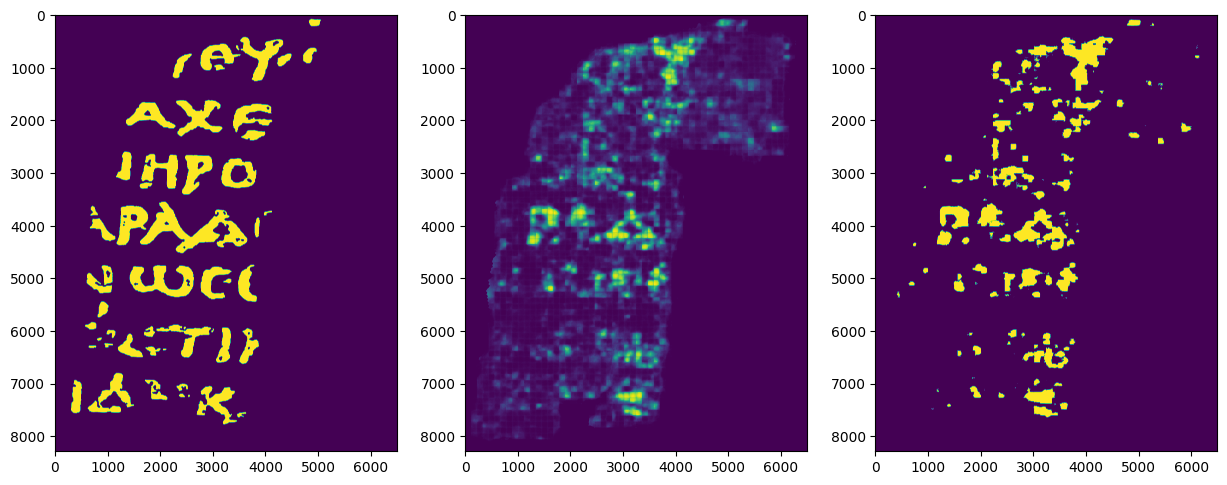

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([38111895.,  5863049.,  2683724.,  1614673.,  1077518.,   729974.,
          599927.,   505344.,   420908.,   350079.,   289053.,   256639.,
          241145.,   213722.,   193215.,   182844.,   163006.,   157653.,
          133724.,    50756.]),
 array([4.13068271e-07, 4.88816371e-02, 9.77628611e-02, 1.46644085e-01,
        1.95525309e-01, 2.44406533e-01, 2.93287757e-01, 3.42168981e-01,
        3.91050205e-01, 4.39931429e-01, 4.88812653e-01, 5.37693877e-01,
        5.86575101e-01, 6.35456325e-01, 6.84337549e-01, 7.33218773e-01,
        7.82099997e-01, 8.30981221e-01, 8.79862445e-01, 9.28743669e-01,
        9.77624893e-01]),
 <BarContainer object of 20 artists>)

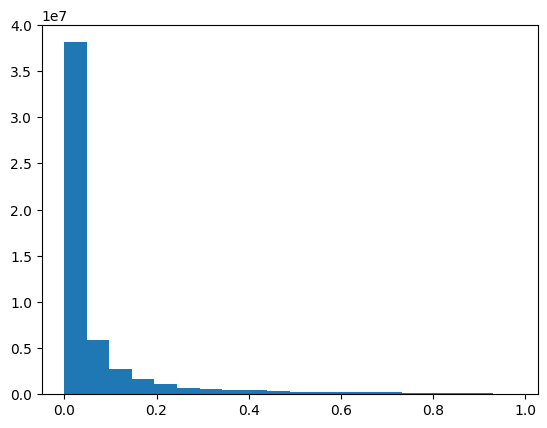

In [34]:
plt.hist(mask_pred.flatten(), bins=20)